Importing necessary Libraries.

In [0]:
import numpy as np
import pandas as pd
import operator
import random
import matplotlib.pyplot as plt


**Genetic Algorithm for Travelling Salesman Problem**

Steps:
1. Creating the population
2. Determining the fittest
3. Selecting the mating pool
4. Breed
5. Mutate
6. Repeat

**The terms used interchangebly are**

1. cities --> gene
2. route --> chromosome
3. list of routes --> population

**1. Creating the classes for City and their Fitness**

**City** class --> This class has mehtods like distance and represenation for the city cordinates. 

**Fitness** class --> This class has the methods to claculate the distance and fitness.

In [0]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        x_distance = abs(self.x - city.x)
        y_distance = abs(self.y - city.y)
        distance = np.sqrt((x_distance ** 2) + (y_distance ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [0]:
#Fitness class to calculate the route distance 
#the route fitness is calculated as reverse of the route distance
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

**2. Creating the Population & Route**

The route is created by the resamping of the complete city list.
There are n! combinations of these cities.

Initial population is created by creating random routes.


In [0]:
#helper function to create routes from list of cities
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [0]:
#helper function to create a sample of initial population from list of cities
def createinitialPopulation(population_size, cityList):
    new_population = []
    for i in range(0, population_size):
        new_population.append(createRoute(cityList))
    return new_population

**3. Determining the Fitness**

The fitness is determined by the reverse of the distance. This fitness is used to rank the route.

Then the route is sorted.

In [0]:
#helper function to calculate the fitness, rank and then sort according to the fitness
def rankRoutes(population):
    fitness_results = {}
    for i in range(0,len(population)):
        fitness_results[i] = Fitness(population[i]).routeFitness()
    return sorted(fitness_results.items(), key = operator.itemgetter(1), reverse = True)

**4. Selecting Parents for Mating**

The parents for mating are chosen on the basis of survival of the fittest. 

i.e. The concept of **Elitism** is used. 

Thus, this algorithm is a bit baised towards the more fitter route.

In [0]:
def selection(ranked_population, elite_size):
    selected_parents = []
    df = pd.DataFrame(np.array(ranked_population), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, elite_size):
        selected_parents.append(ranked_population[i][0])
    for i in range(0, len(ranked_population) - elite_size):
        pick = 100*random.random()
        for i in range(0, len(ranked_population)):
            if pick <= df.iat[i,3]:
                selected_parents.append(ranked_population[i][0])
                break
    return selected_parents

In [0]:
#creating the mating pool with the parents selected from the parents
def matingPool(population, selected_parents):
    mating_pool = []
    for i in range(0, len(selected_parents)):
        index = selected_parents[i]
        mating_pool.append(population[index])
    return mating_pool

**4. Creating the Breed**

The breed is created using the genes from the first and the second parent. 

Thus, the children is combination of both the parent routes.

In [0]:
#creating the children by selecting a part from 1st parent and then replacing the cities not present in another 2nd parent
def breed(parent1, parent2):
    child = []
    child_from_P1 = []
    child_from_P2 = []

    index1 = int(random.random() * len(parent1))
    index2 = int(random.random() * len(parent1))
    startGene = min(index1, index2)
    endGene = max(index2, index1)

    for i in range(startGene, endGene):
        child_from_P1.append(parent1[i])
    child_from_P2 = [gene for gene in parent2 if gene not in child_from_P1]

    child = child_from_P1 + child_from_P2
    return child

In [0]:
#helper function for creating a population using the breeding method
def breedPopulation(mating_pool, elite_size):
    children = []
    length = len(mating_pool) - elite_size
    pool = random.sample(mating_pool, len(mating_pool))

    for i in range(0,elite_size):
        children.append(mating_pool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(mating_pool)-i-1])
        children.append(child)
    return children

**5. Swap Mutation**

In swap mutation, the cities in the route are interchanged and swapped to create new chromosomes i.e. routes.|

In [0]:
#the chance of muation is small and two cities are swapped in the route
def mutate(individual_route, mutation_rate):
    for swap in range(len(individual_route)):
        if(random.random() < mutation_rate):
            swap_with = int(random.random() * len(individual_route))
            individual_route[swap], individual_route[swap_with] = individual_route[swap_with], individual_route[swap]
    return individual_route

In [0]:
#helper function to mutate t
def mutatePopulation(population, mutation_rate):
    mutated_population = []
    
    for index in range(0, len(population)):
        mutated_index = mutate(population[index], mutation_rate)
        mutated_population.append(mutated_index)
    return mutated_population

**6. Creating New Generation using Mutation, Mating and Breeding**

New Generations are crearted having all the operations performed i.e. mutation, breeding and mating.

In [0]:
#Generating new generation of population from the current generation
#this will combine all the process --> selection, mating, mutation, breeding
def nextGeneration(current_generation, elite_size, mutation_rate):
    ranked_population = rankRoutes(current_generation)
    selected_parents = selection(ranked_population, elite_size)
    mating_pool = matingPool(current_generation, selected_parents)
    children = breedPopulation(mating_pool, elite_size)
    new_generation = mutatePopulation(children, mutation_rate)
    return new_generation

**7. Running the Algorithm**

The algorithm is run for certain number of generations, which is a parameter for number of times, the algorithm repeats itself and needs to be chosen according to the complexity of the problem.

The other parameters are: 
1. Population --> The total number of chromosomes. (list of cities)
2. population_size --> The population size i.e. size of list of the cities.
3. elite_size --> The number of samples to take from the fittest candidates.
4. mutation_rate --> The rate of the mutation used to perform mutation few number of times.
5. generations --> The total number of generations the algorithm runs for.

In [0]:
def geneticAlgorithmWithPlot(population, population_size, elite_size, mutation_rate, generations):
    new_population = createInitialPopulation(population_size, population)
    distances = []
    distances.append(1 / rankRoutes(new_population)[0][1])
 
    print("Initial Distance: " + str((1 / rankRoutes(new_population)[0][1])))
    for i in range(0, generations):
        new_population = nextGeneration(new_population, elite_size, mutation_rate)
        distances.append(1 / rankRoutes(new_population)[0][1])
  
    print("Final Distance: " + str((1 / rankRoutes(new_population)[0][1])))
    
    plt.plot(distances)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()


Initial Distance: 2125.1028594453364
Final Distance: 1005.7677300979168


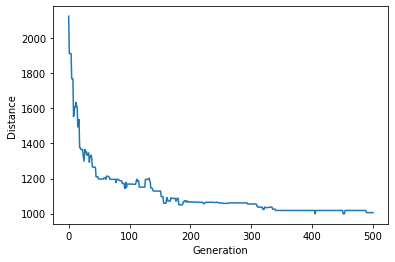

Time:  14.49168180599736 secs


In [620]:
import csv
import timeit 

cities = []
with open('tsp.csv', 'r') as f:
    reader = csv.reader(f)
    i = 0
    for row in reader:
        cities.append(City(x = float(row[1]), y = float(row[2])))

POPULATION_SIZE = 100
ELITE_SIZE = 20
MUTATION_RATE = 0.01
GENERATIONS = 500

start = timeit.default_timer()

geneticAlgorithmWithPlot(population=cities, population_size=POPULATION_SIZE, elite_size=ELITE_SIZE, mutation_rate=MUTATION_RATE, generations=GENERATIONS)

stop = timeit.default_timer()
print('Time: ', stop - start, 'secs') 

**Creating the CSV file for the data**

In [621]:
'''import csv

with open('tsp.csv', 'w') as csvfile:
  filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
  filewriter.writerow(['city', 'x', 'y'])
  for i in range(0,25):
    filewriter.writerow([i, random.random()*200, random.random()*200])'''

"import csv\n\nwith open('tsp.csv', 'w') as csvfile:\n  filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)\n  filewriter.writerow(['city', 'x', 'y'])\n  for i in range(0,25):\n    filewriter.writerow([i, random.random()*200, random.random()*200])"